In [134]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm=ChatGroq(model="llama-3.3-70b-versatile")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003692168, 'queue_time': 0.476389019, 'total_time': 0.053692168}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-f14c1cac-2bbd-4c21-9d39-c44dfb694a37-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [135]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.constants import Send

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from typing import Annotated,List
import operator

In [136]:
# Schema for structured output to use in planning code architecture
class CodeFileType(BaseModel):
    name: str = Field(
        description="Name of the code file with extension",
    )
    description: str = Field(
        description="Description of the functionality in the file",
    )


# Schema for structured output to use in planning
class CodeFile(BaseModel):
    name: str = Field(
        description="Name of the code file with extension",
    )
    code: str = Field(
        description="Code content of the file",
    )


class CodeFileTypes(BaseModel):
    codefiletypes: List[CodeFileType] = Field(
        description="List of code files.",
    )

class CodeFiles(BaseModel):
    codefiles: List[CodeFile] = Field(
        description="List of code files.",
    )


class DesignDocs(BaseModel):
    functional_design: str = Field(
        description="Functional document based on the user requirements",
    )
    technical_design: str = Field(
        description="Technical document based on the user requirements",
    )

In [138]:
class State(TypedDict):
    user_requirements:str
    user_stories_doc:str
    user_stories_review:str
    design_docs:DesignDocs
    design_review:str
    codefiletypes: list[CodeFileType]
    codefiles:List[CodeFile]
    generated_files: Annotated[
        list[CodeFile], operator.add
    ]  # All workers write to this key in parallel
    generated_code: dict 
    code_review:str

# Worker state
class WorkerState(TypedDict):
    codefiletype: CodeFileType
    generated_files: Annotated[list[CodeFile], operator.add]

In [139]:
def user_stories_node(state:State):
    
    user_stories_instructions="""You are tasked with creating a user story based on the given user requirements. 
    Follow these instructions carefully:

    1. First, review the given user requirements carefully:
    {user_requirements}
            
    2. Examine any editorial feedback that has been optionally provided to modify the already generated user story : {user_story} and modify accordingly: 
            
    {user_stories_review}.

    3. Use mark down formatting and include no preamble.
    """
    user_stories_review=state.get('user_stories_review', '')
    user_story=state.get('user_stories_doc', '')
    response=llm.invoke(user_stories_instructions.format(user_requirements=state["user_requirements"],
                                                         user_story=user_story,
                                                         user_stories_review=user_stories_review))
    return {"user_stories_doc":response.content}

# no-op node that should be interrupted on
def human_fb_userstory(state: State):
    pass

# no-op node that should be interrupted on
def human_fb_design(state: State):
    pass

# no-op node that should be interrupted on
def human_fb_code(state: State):
    pass

In [140]:
def user_story_review(state: State):
    """ Return the next node to execute """
    # Check if human feedback
    user_stories_review=state.get('user_stories_review', None)
    print("IN USER STORY REVIEW :",user_stories_review)
    if user_stories_review:
        return "user_stories_node"
    
    # Otherwise design_documents_node
    return "design_documents_node"

In [141]:
def design_documents_node(state:State):
    
   design_documents_instructions = """
   You are tasked with creating two design documents - functional and technical respectively, based
   on the given user stories. Follow these instructions carefully:

   1. First, review the given user stories carefully:
   {user_stories_doc}

   2. The "functional_design" section should include an introduction, system overview, functional requirements, and use cases.
      The "technical_design" section should include the architecture, technology stack, database schema, API specifications,deployment 
      and security considerations.

   3. If editorial feedback is provided, you **must** update the existing design documents accordingly. The feedback is:  
      {design_review}

      - Classify each feedback item:
      - If it relates to **features, user experience, or functionality**, modify the **functional_design** section.
      - If it relates to **database, hosting, security, or APIs**, modify the **technical_design** section.

      - Identify the relevant sections in the existing design document:  
      {design_doc}

      - **Modify** the existing document where necessary. 

   4. Return the software design document in JSON format with two keys: "functional_design" and "technical_design".
      Each section must be formatted as a Markdown document inside the JSON output. No preamble.
   
   5. The files should cover all aspects of coding including front end and backend code based on the design.

   """

   design_review=state.get("design_review", "")
   print("IN DESIGN DOCS GEN : ",design_review)
   design_doc=state.get("design_docs", "")
   design_creator=llm.with_structured_output(DesignDocs)
   response=design_creator.invoke(design_documents_instructions.format(user_stories_doc=state["user_stories_doc"],
                                                                     design_doc=design_doc,
                                                                     design_review=design_review))
   return {"design_docs":response}

In [142]:
def design_doc_review(state: State):
    """ Return the next node to execute """
    # Check if human feedback
    design_review=state.get('design_review', None)
    print("IN DESIGN REVIEW :",design_review)
    if design_review:
        return "design_documents_node"
    
    # Otherwise code_generation_node
    return "code_gen_orchestrator"

In [143]:
# def code_generation_node(state: State):

#     code_gen_instructions="""
#     You are tasked with generating high-quality, production-ready code based on the given design document. Follow these instructions carefully:  

#     1. **Review the provided design document carefully:**  
#     {design_docs}  

#     - The "functional_design" section outlines system behavior, user requirements, and expected workflows.  
#     - The "technical_design" section details the architecture, technology stack, database schema, API specifications, deployment, and security considerations.  

#     2. **Generate well-structured code** based on the specifications:  
#     - The files should cover all aspects of coding including front end and backend code based on the design using best coding practices.  
#     - Adhere to the specified architecture, design patterns, and technology stack.  
#     - Organize the code into appropriate modules, classes, and functions.
#     - Place similar files to same sub folder based on functionality.
#     - Use meaningful variable names, function names, and inline comments.  
#     - Optimize for performance, scalability, and maintainability.  

#     3. **Output Format:**  
#     - Return a JSON object following this structure:  
#     {{
#         "codefiles": [
#             {{
#                 "name": "filename.ext",
#                 "description": "Brief explanation of the file's purpose.",
#                 "code": "Complete source code for the file as a string."
#             }}
#         ]
#     }}

#     Example Output:
#     {{
#         "codefiles": [
#             {{
#                 "name": "app.py",
#                 "description": "Flask application entry point.",
#                 "code": "from flask import Flask\\napp = Flask(__name__)\\n@app.route('/')\\ndef home():\\n    return 'Hello, World!'\\nif __name__ == '__main__':\\n    app.run(debug=True)"
#             }},
#             {{
#                 "name": "utils.py",
#                 "description": "Utility functions for common operations.",
#                 "code": "def add(a, b):\\n    return a + b"
#             }}
#         ]
#     }}
#     """
#     code_gen_instructions_prev = """
#     You are tasked with generating high-quality, production-ready code based on the given design document. Follow these instructions carefully:  

#     1. **Review the provided design document carefully:**  
#     {design_docs}  

#     - The `"functional_design"` section outlines system behavior, user requirements, and expected workflows.  
#     - The `"technical_design"` section details the architecture, technology stack, database schema, API specifications, deployment, and security considerations.  

#     2. **Generate multiple well-structured code files** based on the specifications:  
#     - Implement all necessary functionality using best coding practices in a modular coding pattern .  
#     - Adhere to the specified architecture, design patterns, and technology stack.  
#     - Organize the code into appropriate modules, classes, functions and use multiple files for seperate functionalities.  
#     - Use meaningful variable names, function names,file names and inline comments.  
#     - Optimize for performance, scalability, and maintainability.  

#     3. **If editorial feedback is provided, update the existing code accordingly:**  
#     {code_review}  

#     - Classify each feedback item:  
#         - If it relates to **business logic, features, or user experience**, modify the **functional aspects** of the code accordingly.  
#         - If it relates to **performance, security, database, or API integration**, modify the **technical implementation** accordingly.  

#     - Identify the relevant code files in the optional existing implementation based on feedback:  
#     {generated_code}  

#     - **Modify** the existing code where necessary. Do not regenerate the entire codebase unless required.  

#     4. **Output Format:**  
#     - Return a JSON object following this structure:  
#         - `"codefiles"`: A list of code files, where each file is a dictionary with the following fields:  
#             - `"name"`: The filename with its extension (e.g., `"main.py"`).  
#             - `"description"`: A brief explanation of the file's purpose.  
#             - `"code"`: The complete source code for that file as a string.  
#     - Ensure the output strictly conforms to this schema.

#     Example Output:
#     ```json
#     {
#         "codefiles": [
#             {
#                 "name": "app.py",
#                 "description": "Flask application entry point.",
#                 "code": "from flask import Flask\napp = Flask(__name__)\n@app.route('/')\ndef home():\n    return 'Hello, World!'\nif __name__ == '__main__':\n    app.run(debug=True)"
#             },
#             {
#                 "name": "utils.py",
#                 "description": "Utility functions for common operations.",
#                 "code": "def add(a, b):\n    return a + b"
#             }
#         ]
#     }
#     ```
#     """

#     # Retrieve state variables safely
#     #code_review = state.get("code_review", "")
#     design_docs = state.get("design_docs")
#     if not design_docs:
#         raise ValueError("Missing 'design_docs' in state")  # Prevents KeyError

#     # Ensure codefiles is a valid CodeFiles object, not an empty string
#     #codefiles = state.get("codefiles", CodeFiles(codefiles=[]))

#     # Debugging print statements
#     #print("IN CODE GEN : ", code_review)

#     # generated_code = codefiles.model_dump_json()
#     # if not generated_code:
#     #     generated_code = '{"codefiles": []}'
    
#     # print("Existing Code Files: ", generated_code) 
#     print('IN CODE GEN')
#     # Ensure LLM output follows the expected structure
#     code_generator = llm.with_structured_output(CodeFiles)
    
#     code_gen_input = code_gen_instructions.format(
#         design_docs=design_docs,
#     )

#     try:
#         codefiles = code_generator.invoke(code_gen_input)
#         print("Raw LLM Response:", codefiles.codefiles)  # Debugging output

#         # if not isinstance(codefiles, dict):
#         #     raise ValueError(f"Invalid LLM response type: {type(codefiles)}")

#         # # Parse structured output
#         # if "codefiles" not in codefiles:
#         #     raise KeyError("Missing 'codefiles' key in LLM response")

#         return {"codefiles": codefiles.codefiles}

#     except Exception as e:
#         print(f"Error in LLM invocation: {e}")
#         return {"codefiles": []}  # Return empty list in case of failure


In [144]:
# Nodes
def code_gen_orchestrator(state: State):
    """Orchestrator that generates an architecture plan for the code"""

    orchestrator_instrns="""
    Generate a production-level code architecture plan based on the provided design document. Follow these instructions carefully to ensure a structured and well-organized folder hierarchy:
    1. Define the sub folder structure based on the design documents for placing files of related functionalities.
    2. Determine file structure: Generate unique file names with appropriate extensions based on all functionalities specified in the design document.Limit the number of files to 10.
    3. Group related files into subfolders based on their functionality.
    4. Ensure correct naming convention:
    - For each file, include its full path within the "name" key 
    - Ensure every file is assigned to a subfolder when applicable.
    5. Provide meaningful descriptions: Each file should have a clear and concise description under the "description" key, explaining its purpose and role in the system.
    6. Output format: Return a JSON object containing multiple file entries, each with "name" and "description" keys for multiple files
    7. Production-ready best practices: Ensure the folder structure is scalable, modular, aligning with industry standards for production environments.
    """
    # Augment the LLM with schema for structured output
    planner = llm.with_structured_output(CodeFileTypes)
    # Generate queries
    code_files = planner.invoke(
        [
            SystemMessage(content=orchestrator_instrns),
            HumanMessage(content=f"Here is the functional and technical design: {state["design_docs"]}"),
        ]
    )

    print("Code file structure:",code_files)

    return {"codefiletypes": code_files.codefiletypes}

In [145]:
def code_generation_node(state: WorkerState):
    """Worker writes each code file"""
    
    coder_llm=llm.with_structured_output(CodeFile)
    code_gen_instrns="""
    Write a code contents for the code file based on the description given.Follow the below instructions carefully.
    1. Check for any optional feedback {code_review} and generate the code accordingly.
    2. Return the 'name' and 'code' for the file in JSON format.
    """
    # Generate section
    code_file = coder_llm.invoke(
        [
            SystemMessage(
                content=code_gen_instrns.format(code_review=state['code_review'])
            ),
            HumanMessage(
                content=f"Here is the file name: {state['codefiletype'].name} and description: {state['codefiletype'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"generated_files": [code_file]}

In [146]:
# Conditional edge function to create code_generation_node workers that each write each code file
def assign_workers(state: State):
    """Assign a worker to each code file in the plan"""
    code_review=state.get('code_review','')
    # Kick off section writing in parallel via Send() API
    return [Send("code_generation_node", {"code_review":code_review,"codefiletype": s}) for s in state["codefiletypes"]]

In [ ]:
def code_synthesizer(state: State):
    """Synthesize full code from multiple code files"""
    # Check if human feedback
    code_review=state.get('code_review', None)
    print("IN code_synthesizer review is :",code_review)
    if code_review:
        modifier_files=llm.with_structured_output(CodeFileTypes)
        file_modify_instrns="""
        Examine the code review feedback provided :{code_review}.
        The existing code file names with the descriptions is as provided : {codefiletypes}
        Identify the code file names that need modifications based on the descriptions and feedback provided.
        If feedback requires new files to be added,provide file name and description accordingly.
        Return the files to be modified with names and descriptions as a JSON object 
        """
        modified_files=modifier_files.invoke(
            file_modify_instrns.format(code_review=code_review,codefiletypes=state['codefiletypes']))
        print("FILES TO BE MODIFIED BASED ON FEEDBACK ",modified_files)
        # modifier_code=[Send("code_generation_node", {"codefiletype": s}) for s in modified_files]
        # print("MODIFIED CODE: ",modifier_code)


        
    # List of completed sections
    generated_files = state["generated_files"]
    # Convert to dictionary format: {filename: code}
    generated_code = {code_file.name: code_file.code for code_file in generated_files}
    print(generated_code)
    return {"generated_code": generated_code}

In [148]:
def code_gen_review(state: State):
    """ Return the next node to execute """
    # Check if human feedback
    code_review=state.get('code_review', None)
    print("IN CODE REVIEW :",code_review)
    if code_review:
        return "code_synthesizer"
    
    # Otherwise end
    return END

In [149]:
# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("user_stories_node", user_stories_node)
builder.add_node("human_fb_userstory", human_fb_userstory)
builder.add_node("design_documents_node", design_documents_node)
builder.add_node("human_fb_design", human_fb_design)
builder.add_node("code_gen_orchestrator", code_gen_orchestrator)
builder.add_node("code_generation_node", code_generation_node)
builder.add_node("code_synthesizer", code_synthesizer)
builder.add_node("human_fb_code", human_fb_code)

builder.add_edge(START, "user_stories_node")
builder.add_edge("user_stories_node", "human_fb_userstory")
builder.add_conditional_edges("human_fb_userstory", user_story_review, ["user_stories_node", "design_documents_node"])
builder.add_edge("design_documents_node", "human_fb_design")
builder.add_conditional_edges("human_fb_design", design_doc_review, ["design_documents_node", "code_gen_orchestrator"])
builder.add_conditional_edges("code_gen_orchestrator", assign_workers, ["code_generation_node"])
builder.add_edge("code_generation_node", "code_synthesizer")
builder.add_edge("code_synthesizer", "human_fb_code")
builder.add_conditional_edges("human_fb_code", code_gen_review, ["code_synthesizer", END])

In [150]:
memory = MemorySaver()
thread={"configurable":{"thread_id":"1"}}

In [151]:
graph = builder.compile(interrupt_before=["human_fb_userstory","human_fb_design","human_fb_code"], checkpointer=memory)

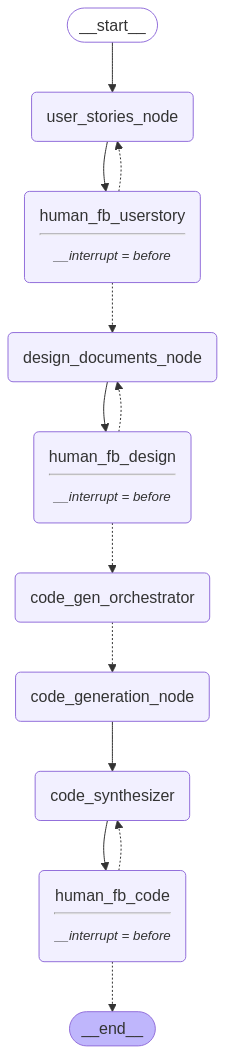

In [152]:
# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [153]:
# Run the graph until the first interruption
for event in graph.stream({"user_requirements":"Develop a shopping site website in python"}, thread, stream_mode="values"):
    user_stories_doc=event.get("user_stories_doc",'')
 

In [154]:
with open("user_stories.md", "w", encoding="utf-8") as f: 
    f.write(user_stories_doc)


In [155]:
state=graph.get_state(thread)
state.next

('human_fb_userstory',)

In [156]:
# We now update the state for human_feedback node
graph.update_state(thread, {"user_stories_review": 
                            "Add section for home page display specifications"}, as_node="human_fb_userstory")

IN USER STORY REVIEW : Add section for home page display specifications


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f002839-7e78-6481-8002-1a7053881ec7'}}

In [157]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    user_stories_doc = event.get('user_stories_doc', '')


In [158]:
with open("user_stories_review.md", "w", encoding="utf-8") as f: 
    f.write(user_stories_doc)

In [159]:
# We now update the state for human_feedback node with no feedback
graph.update_state(thread, {"user_stories_review": 
                            ""}, as_node="human_fb_userstory")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    design_docs = event.get('design_docs', '')

IN USER STORY REVIEW : 
IN DESIGN DOCS GEN :  


In [160]:
with open("functional_design.md", "w", encoding="utf-8") as f: 
    f.write(design_docs.functional_design)

In [161]:
with open("technical_design.md", "w", encoding="utf-8") as f: 
    f.write(design_docs.technical_design)

In [162]:
# We now update the state for human_feedback node
graph.update_state(thread, {"design_review": 
                            "Change the database to SQL and host it in Azure.Also add a wishlist for the user to add products for later use."},
                              as_node="human_fb_design")

IN DESIGN REVIEW : Change the database to SQL and host it in Azure.Also add a wishlist for the user to add products for later use.


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f002839-b6ff-629a-8006-d2b1986aa353'}}

In [163]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    design_docs = event.get('design_docs', '')
    print(design_docs)

functional_design='# Functional Design Document\n\n## Introduction\nThis document outlines the functional design for the Shopping Site Website.\n\n## System Overview\nThe Shopping Site Website allows users to browse and purchase products online with a user-friendly interface.\n\n## Functional Requirements\n- **Display Featured Products:** The home page will feature a slider of popular products to attract user attention.\n- **Search Functionality:** Users should be able to type in a search term to find specific products.\n- **Product Categories:** A section of the homepage will show categories with thumbnail images for quick navigation.\n- **Highlight New Arrivals and Bestsellers:** A dedicated section will display new arrivals and top-selling products.\n\n## Use Cases\n- **UC1:** User accesses the homepage and sees featured products.\n- **UC2:** User uses the search bar to find a specific product.\n- **UC3:** User navigates categories to explore product offerings.\n- **UC4:** User view

In [164]:
with open("functional_design_review.md", "w", encoding="utf-8") as f: 
    f.write(design_docs.functional_design)

with open("technical_design_review.md", "w", encoding="utf-8") as f: 
    f.write(design_docs.technical_design)

In [165]:
# We now update the state for human_feedback node with no feedback
graph.update_state(thread, {"design_review": 
                            ""}, as_node="human_fb_design")
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    generated_code = event.get('generated_code', '')
    if generated_code:
        # Create the output directory if it doesn't exist
        output_dir = "generated_code"
        os.makedirs(output_dir, exist_ok=True)
        for file_name, code_content in generated_code.items():
            # Construct the full file path inside the output directory
            full_file_path = os.path.join(output_dir, file_name)
            # Extract and create the necessary folder structure
            folder_path = os.path.dirname(full_file_path)
            os.makedirs(folder_path, exist_ok=True)
            # Write the code content to the file
            with open(full_file_path, "w", encoding="utf-8") as f:
                f.write(code_content)

            print(f"Created file: {full_file_path}")

IN DESIGN REVIEW : 
Code file structure: codefiletypes=[CodeFileType(name='frontend/src/App.js', description='Main entry point for the React application, managing the top-level components.'), CodeFileType(name='frontend/src/components/ProductSlider.js', description='Component to display the slider of featured products on the homepage.'), CodeFileType(name='frontend/src/components/SearchBar.js', description='Component for the search input field allowing users to enter search terms.'), CodeFileType(name='frontend/src/components/CategoryGrid.js', description='Component to showcase product categories with thumbnail images.'), CodeFileType(name='frontend/src/components/WishlistManager.js', description='Component for managing the wishlist feature, including adding and removing products.'), CodeFileType(name='backend/app.py', description='Main server file for the Flask application, defining routes and handling business logic.'), CodeFileType(name='backend/models.py', description='File contain

In [166]:
# We now update the state for human_feedback node
graph.update_state(thread, {"code_review": 
                            "Add a new Homepage.js file to display the landing page with some custom styles.Also make email & username as unique in models.py"},
                              as_node="human_fb_code")

IN CODE REVIEW : Add a new Homepage.js file to display the landing page with some custom styles.Also make email & username as unique in models.py


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00284a-0549-6ad8-800c-bce92641c8bd'}}

In [167]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    generated_code = event.get('generated_code', '')
    print(generated_code)

{'frontend/src/App.js': 'import React from \'react\';\nimport \'./App.css\';\n\nfunction App() {\n  return (\n    <div className="App">\n      <header className="App-header">\n        <h1>Welcome to the React App</h1>\n      </header>\n    </div>\n  );\n}\n\nexport default App;\n', 'frontend/src/components/ProductSlider.js': 'import React from \'react\';\nimport \'./ProductSlider.css\';  // Assuming you want to add some custom styles\n\n// You may need to import a slider library or use a standard carousel component\n\nconst ProductSlider = () => {\n  // Logic to fetch or receive product data\n  const products = [];\n\n  return (\n    <div className="product-slider">\n      <h2>Featured Products</h2>\n      <div className="slider-container">\n        {/* Slider or carousel component goes here */}\n        {products.map(product => (\n          <div key={product.id} className="product-item">\n            <img src={product.image} alt={product.name} />\n            <h3>{product.name}</h3>\n

In [100]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    generated_code = event.get('generated_code', '')
    print(generated_code)

{'src/frontend/components/ProductList.js': 'import React from \'react\';\nimport PropTypes from \'prop-types\';\n\nconst ProductList = ({ products }) => {\n  return (\n    <div className="product-list">\n      {products.map(product => (\n        <div key={product.id} className="product" data-category={product.category}>\n          <h2>{product.name}</h2>\n          <p>{product.description}</p>\n        </div>\n      ))}\n    </div>\n  );\n};\n\nProductList.propTypes = {\n  products: PropTypes.arrayOf(\n    PropTypes.shape({\n      id: PropTypes.number.isRequired,\n      name: PropTypes.string.isRequired,\n      category: PropTypes.string.isRequired,\n      description: PropTypes.string.isRequired,\n    })\n  ).isRequired,\n};\n\nexport default ProductList;', 'src/frontend/components/Cart.js': "import React, { useState } from 'react';\n\nconst Cart = () => {\n  const [cartItems, setCartItems] = useState([]);\n\n  const addItem = (item) => {\n    setCartItems([...cartItems, item]);\n  };

## ORCHESTRATOR SAMPLE IMPLMN

In [132]:
#Orchestrator to generate code

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class CodeFileType(BaseModel):
    name: str = Field(
        description="Name of the code file with extension",
    )
    description: str = Field(
        description="Description of the functionality in the file",
    )


# Schema for structured output to use in planning
class CodeFile(BaseModel):
    name: str = Field(
        description="Name of the code file with extension",
    )
    code: str = Field(
        description="Code content of the file",
    )


class CodeFileTypes(BaseModel):
    codefiletypes: List[CodeFileType] = Field(
        description="List of code files.",
    )

# class CodeFiles(BaseModel):
#     codefiles: List[CodeFile] = Field(
#         description="List of code files.",
#     )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(CodeFileTypes)

In [133]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    design_docs: str  # Report topic
    codefiletypes: list[CodeFileType]  # List of report sections
    codefiles: list[CodeFile]  # List of report sections
    generated_files: Annotated[
        list[CodeFile], operator.add
    ]  # All workers write to this key in parallel
    generated_code: str  # Final generated code

# Worker state
class WorkerState(TypedDict):
    codefiletype: CodeFileType
    generated_files: Annotated[list[CodeFile], operator.add]

In [134]:
design_docs

DesignDocs(functional_design="# Functional Design Document\n\n## Introduction\nThis document outlines the functional design of the shopping website developed using Python. It aims to provide a comprehensive overview of the system's functionalities, intended to enhance the user experience and meet the requirements specified in the user stories.\n\n## System Overview\nThe shopping website will allow users to register, browse products, add items to their cart, and complete purchases. The system is designed to provide a seamless shopping experience for users through an intuitive and user-friendly interface.\n\n## Functional Requirements\n1. User registration and login system\n2. Product browsing with descriptions and price display\n3. Cart functionality allowing users to add products and view their selections\n4. Checkout process with secure payment and shipping information collection\n5. Home page showcasing a welcome message, featured products, and a call to action\n6. Wishlist functiona

In [ ]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the code"""

    orchestrator_instrns="""
    Generate a production-level code architecture plan based on the provided design document. Follow these instructions carefully to ensure a structured and well-organized folder hierarchy:
    1. Define the sub folder structure based on the design documents for placing files of related functionalities.
    2. Determine file structure: Generate file names with appropriate extensions based on all functionalities specified in the design document.Limit the number of files to 10.
    3. Group related files into subfolders based on their functionality.
    4. Ensure correct naming convention:
    - For each file, include its full path within the "name" key 
    - Ensure every file is assigned to a subfolder when applicable.
    5. Provide meaningful descriptions: Each file should have a clear and concise description under the "description" key, explaining its purpose and role in the system.
    6. Output format: Return a JSON object containing multiple file entries, each with "name" and "description" keys for multiple files
    7. Production-ready best practices: Ensure the folder structure is scalable, modular, aligning with industry standards for production environments.
    """

    # Generate queries
    code_files = planner.invoke(
        [
            SystemMessage(content=orchestrator_instrns),
            HumanMessage(content=f"Here is the functional and technical design: {design_docs}"),
        ]
    )

    print("Code file structure:",code_files)

    return {"codefiletypes": code_files.codefiletypes}

In [136]:
def llm_call(state: WorkerState):
    """Worker writes each code file"""
    
    coder_llm=llm.with_structured_output(CodeFile)
    # Generate section
    code_file = coder_llm.invoke(
        [
            SystemMessage(
                content="Write a code contents for the code file based on the description given. Return the 'name' and 'code' for the file in JSON format."
            ),
            HumanMessage(
                content=f"Here is the file name: {state['codefiletype'].name} and description: {state['codefiletype'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"generated_files": [code_file]}

In [137]:
# Conditional edge function to create llm_call workers that each write each code file
def assign_workers(state: State):
    """Assign a worker to each code file in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"codefiletype": s}) for s in state["codefiletypes"]]

In [158]:
from itertools import chain
def synthesizer(state: State):
    """Synthesize full code from multiple code files"""

    # List of completed sections
    generated_files = state["generated_files"]
    # Convert to dictionary format: {filename: code}
    generated_code = {code_file.name: code_file.code for code_file in generated_files}
    print(generated_code)
    return {"generated_code": generated_code}


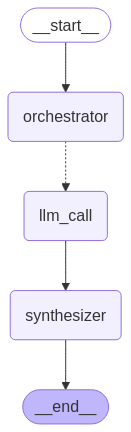

In [159]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))



In [160]:
# Invoke
response = orchestrator_worker.invoke({"design_docs": design_docs})



Code file structure: codefiletypes=[CodeFileType(name='src/app.py', description='Main entry point of the application. It sets up the Flask server and routes.'), CodeFileType(name='src/users.py', description='Contains functions for user registration, login, and logout. Handles user session management.'), CodeFileType(name='src/products.py', description='Includes functions for browsing and viewing product details. Manages the product data in the database.'), CodeFileType(name='src/cart.py', description='Provides functionalities to add, remove, and view items in the cart. Interacts with the database for cart data management.'), CodeFileType(name='src/checkout.py', description='Handles the checkout process, including payment and order submission. Integrates with secure payment gateways.'), CodeFileType(name='src/wishlist.py', description='Contains functions for adding, removing, and viewing items in the wishlist. Manages wishlist data in the database.'), CodeFileType(name='src/templates/ho

In [161]:
response['generated_code']

{'src/app.py': "from flask import Flask\n\napp = Flask(__name__)\n\n@app.route('/\\')\ndef home():\n    return 'Welcome to the Flask app!'\n\nif __name__ == '__main__':\n    app.run(debug=True)",
 'src/users.py': 'def register_user(user_data):\n    # Function to register a new user\n    pass\n\ndef login_user(user_credentials):\n    # Function to handle user login\n    pass\n\ndef logout_user(session_id):\n    # Function to handle user logout\n    pass\n\ndef manage_user_session(session_id):\n    # Function to manage user session\n    pass',
 'src/products.py': 'def browse_products():\n    # Code to browse products\n    pass\n\ndef view_product_details(product_id):\n    # Code to view product details\n    pass\n\ndef manage_product_data():\n    # Code to manage product data in the database\n    pass',
 'src/cart.py': 'class Cart:\n    def __init__(self, db_connection):\n        self.db_connection = db_connection\n\n    def add_item(self, item_id, quantity):\n        # Add item to the c

In [162]:
for file_name, code_content in response['generated_code'].items():
    # Create the output directory if it doesn't exist
    output_dir = "generated_code"
    os.makedirs(output_dir, exist_ok=True)
    # Construct the full file path inside the output directory
    full_file_path = os.path.join(output_dir, file_name)
    # Extract and create the necessary folder structure
    folder_path = os.path.dirname(full_file_path)
    os.makedirs(folder_path, exist_ok=True)
    # Write the code content to the file
    with open(full_file_path, "w", encoding="utf-8") as f:
        f.write(code_content)

    print(f"Created file: {full_file_path}")

Created file: generated_code\src/app.py
Created file: generated_code\src/users.py
Created file: generated_code\src/products.py
Created file: generated_code\src/cart.py
Created file: generated_code\src/checkout.py
Created file: generated_code\src/wishlist.py
Created file: generated_code\src/templates/home.html
Created file: generated_code\src/static/styles.css
Created file: generated_code\src/models.py
Created file: generated_code\src/utils.py
